In [1]:
import os
import numpy as np
from custom_datagen import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random

In [2]:
train_img_dir = "BraTS2020_TrainingData\\input_data_3channels\\images\\"
train_mask_dir = "BraTS2020_TrainingData\\input_data_3channels\\masks\\"

In [3]:
#Extracting the file names
img_list = os.listdir(train_img_dir)
mask_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

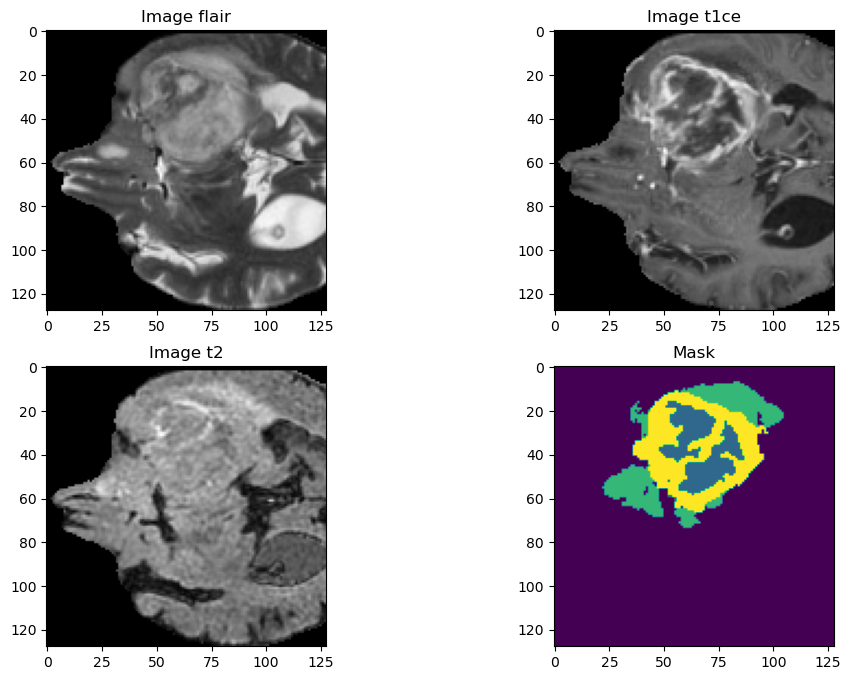

In [32]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+mask_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [5]:
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

# import pandas as pd
# columns = ['0','1', '2', '3']
# df = pd.DataFrame(columns=columns)
# train_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
# for img in range(len(train_mask_list)):
#     print(img)
#     temp_image=np.load(train_mask_list[img])
#     temp_image = np.argmax(temp_image, axis=3)
#     val, counts = np.unique(temp_image, return_counts=True)
#     zipped = zip(columns, counts)
#     conts_dict = dict(zipped)
    
#     df = df.append(conts_dict, ignore_index=True)

# label_0 = df['0'].sum()
# label_1 = df['1'].sum()
# label_2 = df['1'].sum()
# label_3 = df['3'].sum()
# total_labels = label_0 + label_1 + label_2 + label_3
# n_classes = 4
# #Class weights claculation: n_samples / (n_classes * n_samples_for_class)
# wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
# wt1 = round((total_labels/(n_classes*label_1)), 2)
# wt2 = round((total_labels/(n_classes*label_2)), 2)
# wt3 = round((total_labels/(n_classes*label_3)), 2)

# #Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss 

#### Training the Model

In [6]:
train_img_dir = "BraTS2020_TrainingData\\input_data_128\\train\\images\\"
train_mask_dir = "BraTS2020_TrainingData\\input_data_128\\train\\masks\\"

val_img_dir = "BraTS2020_TrainingData\\input_data_128\\val\\images\\"
val_mask_dir = "BraTS2020_TrainingData\\input_data_128\\val\\masks\\"

In [7]:
train_img_list = os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list = os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [8]:
batch_size = 2

In [9]:
train_img_datagen = imageLoader(train_img_dir, train_img_list, train_mask_dir, train_mask_list, batch_size)

In [10]:
val_img_datagen = imageLoader(val_img_dir, val_img_list, val_mask_dir, val_mask_list, batch_size)

In [11]:
img,mask = train_img_datagen.__next__()

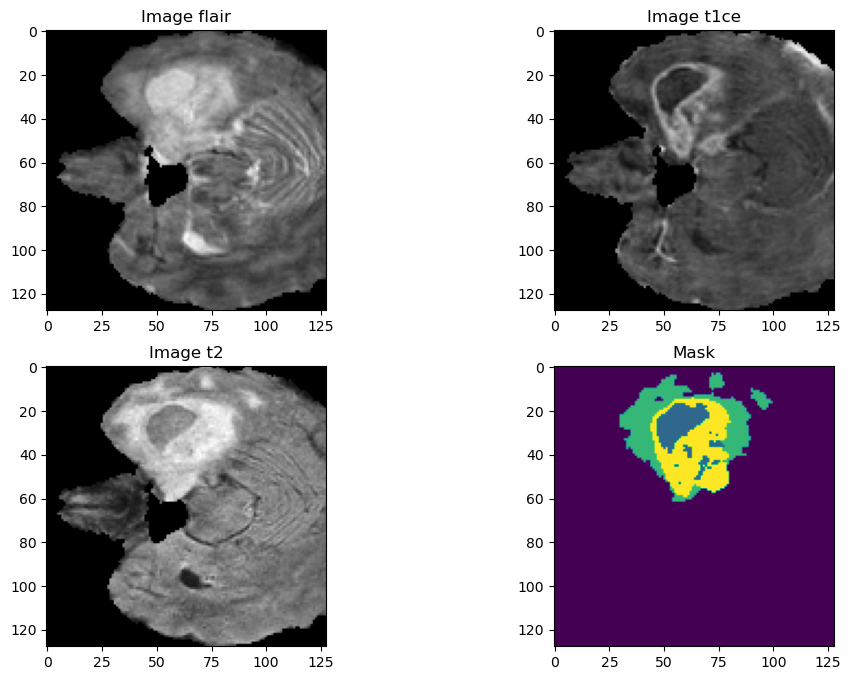

In [38]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=mask[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

### Defining the metrices and optimizers to be used for training

In [13]:
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25
#defining equal weights for all can be changed using above commented code for weight generation

In [14]:
import segmentation_models_3D as sm

Segmentation Models: using `tf.keras` framework.


In [15]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1*focal_loss)

In [16]:
metrics = ['accuracy',sm.metrics.IOUScore(threshold=0.5)]

In [17]:
LR = 0.0001
optim = keras.optimizers.Adam(LR)

#### Fitting The Model ####


In [18]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [19]:
from Model import simple_unet_model

In [20]:
model = simple_unet_model(img_height = 128,
                         img_width = 128,
                         img_depth = 128,
                         img_channels = 3,
                         num_classes = 4)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_12 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_12[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

In [21]:
model.compile(optimizer = optim, loss = total_loss, metrics = metrics)

In [22]:
print(model.summary())
print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

                                                                                                  
 conv3d_12 (Conv3D)             (None, 32, 32, 32,   221248      ['concatenate_1[0][0]']          
                                64)                                                               
                                                                                                  
 dropout_6 (Dropout)            (None, 32, 32, 32,   0           ['conv3d_12[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_13 (Conv3D)             (None, 32, 32, 32,   110656      ['dropout_6[0][0]']              
                                64)                                                               
                                                                                                  
 conv3d_tr

In [ ]:
history = model.fit(train_img_datagen,
                    steps_per_epoch = steps_per_epoch,
                   epochs = 2,
                   verbose = 2,
                   validation_data = val_img_datagen,
                   validation_steps = val_steps_per_epoch,
                   )

Epoch 1/2
